# ML Model Simulation for Healthcare Interventions

This notebook demonstrates how to simulate machine learning models that predict patient risks while maintaining known ground truth, enabling realistic testing of intervention strategies.

## Key Concepts

1. **Performance Constraints**: Mathematical limits on achievable PPV/sensitivity given prevalence
2. **Calibrated Noise**: Adding controlled noise to true labels to achieve target ML performance
3. **Evaluation Modes**: Threshold-based vs TopK selection strategies
4. **Prediction Windows**: How performance varies with prediction horizon
5. **Clinical Integration**: Alert optimization and capacity constraints

## Learning Objectives

- Understand fundamental constraints on ML performance in healthcare
- Simulate realistic ML predictions with known ground truth
- Evaluate intervention strategies under different prediction scenarios
- Optimize clinical decision support given real-world constraints

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve
import warnings
import time
import sys
import os

# Add src directory to path for imports
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Import functions from our modules
from pop_ml_simulator.risk_distribution import (
    assign_patient_risks, simulate_annual_incidents
)
from pop_ml_simulator.temporal_dynamics import (
    simulate_ar1_process, TemporalRiskSimulator, EnhancedTemporalRiskSimulator
)
from pop_ml_simulator.hazard_modeling import (
    annual_risk_to_hazard, hazard_to_timestep_probability,
    IncidentGenerator, CompetingRiskIncidentGenerator
)
from pop_ml_simulator.ml_simulation import (
    MLPredictionSimulator, calculate_theoretical_performance_bounds,
    hosmer_lemeshow_test, evaluate_threshold_based, evaluate_topk,
    optimize_alert_threshold, analyze_risk_stratified_performance
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore', category=RuntimeWarning)

## 1. Performance Modeling Framework

Before simulating ML predictions, we need to understand the fundamental constraints on achievable performance given the prevalence of the outcome.

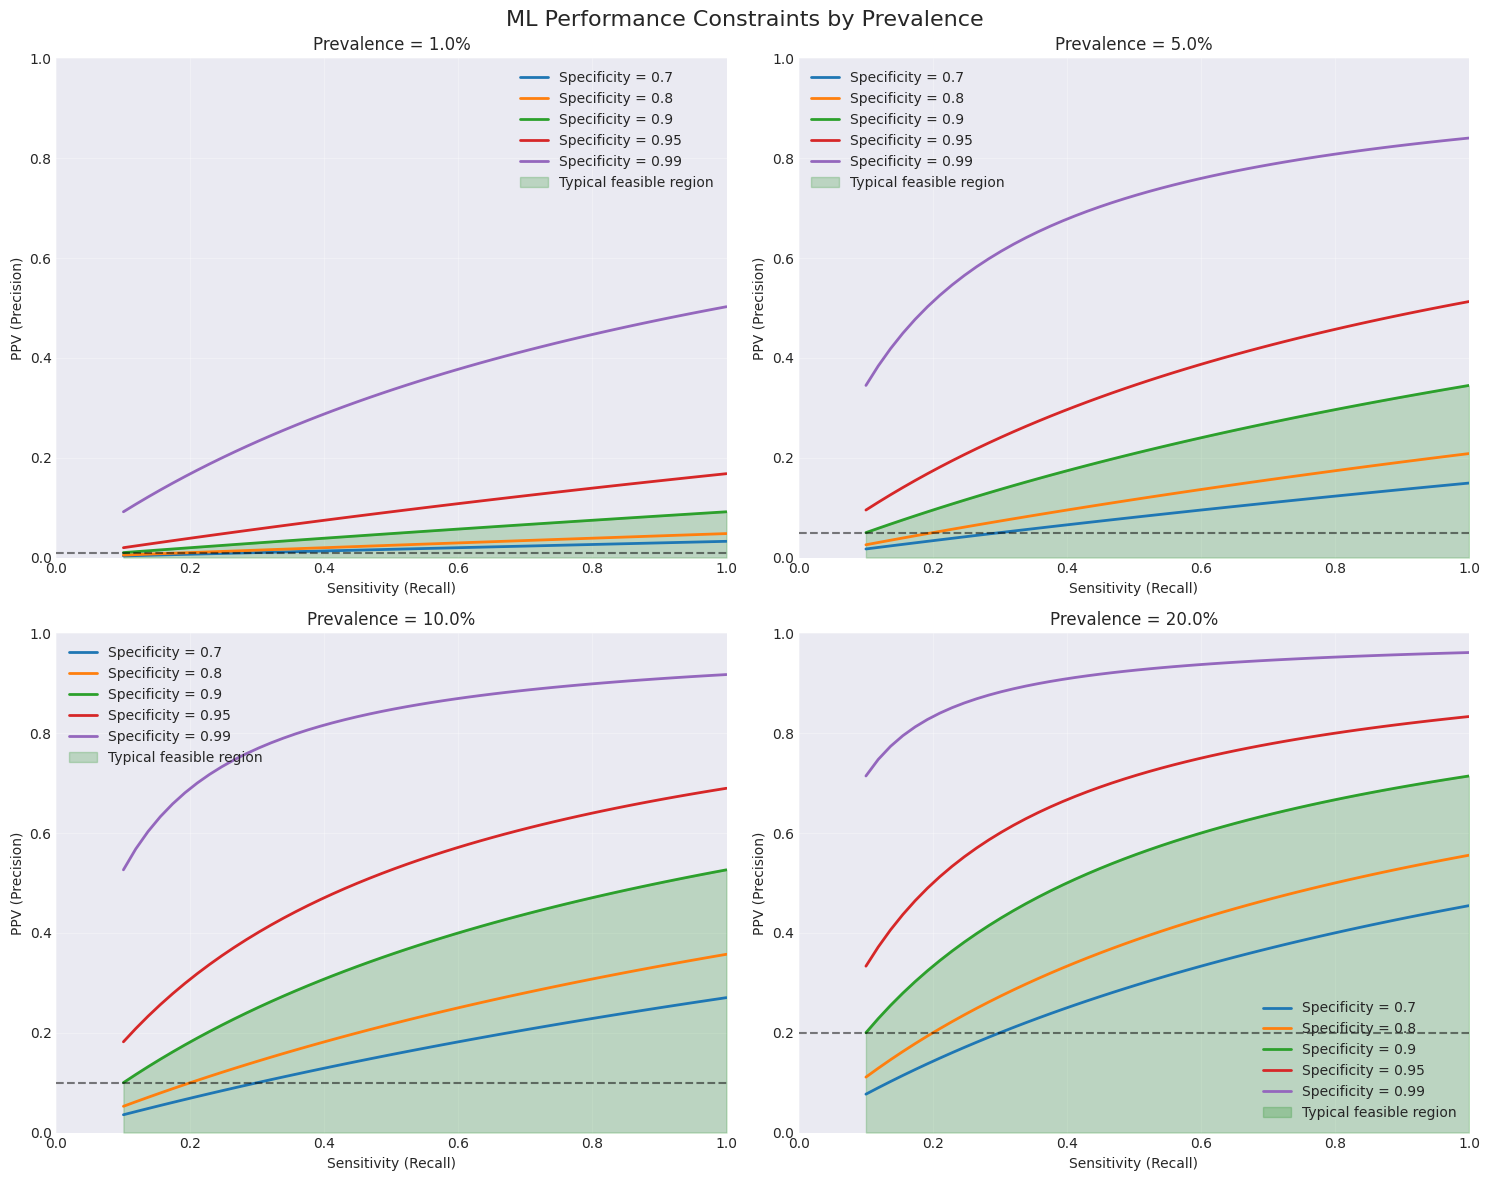

In [2]:
def calculate_theoretical_performance_bounds(prevalence, sensitivity_range=None):
    """
    Calculate theoretical bounds on PPV given sensitivity and prevalence.
    
    For a perfect classifier (specificity = 1.0):
    PPV = (sensitivity * prevalence) / (sens * prevalence + (1 - spec) * (1 - prevalence))
    
    For a more realistic classifier, we need to account for false positives.
    """
    if sensitivity_range is None:
        sensitivity_range = np.linspace(0.1, 1.0, 50)
    
    # Calculate PPV for different specificity values
    specificities = [0.7, 0.8, 0.9, 0.95, 0.99]
    
    results = {}
    for spec in specificities:
        ppvs = []
        for sens in sensitivity_range:
            # Bayes' theorem
            ppv = (sens * prevalence) / (
                sens * prevalence + (1 - spec) * (1 - prevalence)
            )
            ppvs.append(ppv)
        results[f'spec_{spec}'] = ppvs
    
    return sensitivity_range, results


def plot_performance_constraints(prevalences=[0.01, 0.05, 0.1, 0.2]):
    """Visualize how prevalence constrains achievable ML performance."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, prev in enumerate(prevalences):
        ax = axes[i]
        sens_range, ppv_results = calculate_theoretical_performance_bounds(prev)
        
        # Plot curves for different specificities
        for spec_key, ppvs in ppv_results.items():
            spec_val = float(spec_key.split('_')[1])
            ax.plot(sens_range, ppvs, 
                   label=f'Specificity = {spec_val}',
                   linewidth=2)
        
        # Add feasibility region
        ax.fill_between(sens_range, 0, ppv_results['spec_0.9'], 
                       alpha=0.2, color='green', 
                       label='Typical feasible region')
        
        ax.set_xlabel('Sensitivity (Recall)')
        ax.set_ylabel('PPV (Precision)') 
        ax.set_title(f'Prevalence = {prev:.1%}')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        
        # Add diagonal reference line
        ax.plot([0, 1], [prev, prev], 'k--', alpha=0.5, 
               label=f'Random (PPV={prev:.1%})')
    
    plt.suptitle('ML Performance Constraints by Prevalence', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_performance_constraints()

## 2. ML Prediction Mechanics

Now we'll implement the core ML prediction simulator that generates predictions with calibrated noise to achieve target performance metrics.

In [3]:
class MLPredictionSimulator:
    """
    Simulates ML predictions with controlled performance characteristics.
    
    Uses calibrated noise to create predictions that achieve target
    sensitivity and PPV while maintaining realistic patterns.
    """
    
    def __init__(self, target_sensitivity=0.8, target_ppv=0.3, 
                 calibration='sigmoid', random_seed=None):
        """
        Initialize ML prediction simulator.
        
        Parameters
        ----------
        target_sensitivity : float
            Target recall/sensitivity to achieve
        target_ppv : float  
            Target precision/PPV to achieve
        calibration : str
            Calibration function ('sigmoid' or 'isotonic')
        random_seed : int
            Random seed for reproducibility
        """
        self.target_sensitivity = target_sensitivity
        self.target_ppv = target_ppv
        self.calibration = calibration
        self.random_seed = random_seed
        
        # Parameters to be optimized
        self.noise_correlation = None
        self.noise_scale = None
        self.threshold = None
        
    def _apply_calibration(self, scores):
        """Apply calibration function to raw scores."""
        if self.calibration == 'sigmoid':
            # Sigmoid calibration with parameters
            return 1 / (1 + np.exp(-4 * (scores - 0.5)))
        else:
            # Simple clipping for now
            return np.clip(scores, 0, 1)
    
    def generate_predictions(self, true_labels, risk_scores, 
                           noise_correlation=0.7, noise_scale=0.3):
        """
        Generate ML predictions with calibrated noise.
        
        Parameters
        ----------
        true_labels : np.ndarray
            Binary ground truth labels 
        risk_scores : np.ndarray
            True underlying risk scores
        noise_correlation : float
            How much predictions correlate with true risk
        noise_scale : float
            Amount of noise to add
            
        Returns
        -------
        predictions : np.ndarray
            Predicted probabilities
        binary_preds : np.ndarray
            Binary predictions using optimal threshold
        """
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        
        n_patients = len(true_labels)
        
        # Start with true risk scores
        base_scores = risk_scores.copy()
        
        # Add correlated noise
        noise = np.random.normal(0, noise_scale, n_patients)
        
        # Combine with correlation
        noisy_scores = noise_correlation * base_scores + (1 - noise_correlation) * noise
        
        # Add label-dependent noise (true positives get boost, true negatives get reduction)
        label_noise = np.where(true_labels == 1, 
                              np.random.normal(0.2, 0.1, n_patients),
                              np.random.normal(-0.1, 0.1, n_patients))
        
        noisy_scores += label_noise * noise_scale
        
        # Apply calibration
        predictions = self._apply_calibration(noisy_scores)
        
        # Find optimal threshold for target performance
        threshold = self._find_optimal_threshold(true_labels, predictions)
        binary_preds = (predictions >= threshold).astype(int)
        
        return predictions, binary_preds
    
    def _find_optimal_threshold(self, true_labels, predictions):
        """Find threshold that best achieves target metrics."""
        thresholds = np.linspace(0.01, 0.99, 100)
        best_threshold = 0.5
        best_score = float('inf')
        
        for thresh in thresholds:
            binary_preds = (predictions >= thresh).astype(int)
            
            # Calculate metrics
            tp = np.sum((binary_preds == 1) & (true_labels == 1))
            fp = np.sum((binary_preds == 1) & (true_labels == 0))
            fn = np.sum((binary_preds == 0) & (true_labels == 1))
            
            if tp > 0:
                sensitivity = tp / (tp + fn)
                ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
                
                # Score based on distance from targets
                score = abs(sensitivity - self.target_sensitivity) + \
                        abs(ppv - self.target_ppv)
                
                if score < best_score:
                    best_score = score
                    best_threshold = thresh
        
        self.threshold = best_threshold
        return best_threshold
    
    def optimize_noise_parameters(self, true_labels, risk_scores, n_iterations=20):
        """
        Optimize noise parameters to achieve target performance.
        
        Uses grid search to find noise_correlation and noise_scale
        that best achieve target sensitivity and PPV.
        """
        correlations = np.linspace(0.5, 0.95, 10)
        scales = np.linspace(0.1, 0.5, 10)
        
        best_params = {'correlation': 0.7, 'scale': 0.3}
        best_score = float('inf')
        
        for corr in correlations:
            for scale in scales:
                # Average over multiple random seeds
                scores = []
                
                for seed in range(n_iterations):
                    self.random_seed = seed
                    preds, binary = self.generate_predictions(
                        true_labels, risk_scores, corr, scale
                    )
                    
                    # Calculate metrics
                    tp = np.sum((binary == 1) & (true_labels == 1))
                    fp = np.sum((binary == 1) & (true_labels == 0))
                    fn = np.sum((binary == 0) & (true_labels == 1))
                    
                    if tp > 0:
                        sensitivity = tp / (tp + fn)
                        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
                        
                        score = abs(sensitivity - self.target_sensitivity) + \
                                abs(ppv - self.target_ppv)
                        scores.append(score)
                
                avg_score = np.mean(scores) if scores else float('inf')
                
                if avg_score < best_score:
                    best_score = avg_score
                    best_params = {'correlation': corr, 'scale': scale}
        
        self.noise_correlation = best_params['correlation']
        self.noise_scale = best_params['scale']
        
        return best_params

## 3. Demonstration: Generating ML Predictions

Let's demonstrate the ML prediction simulator with a realistic patient population.

In [4]:
# Generate patient population
n_patients = 10000
annual_incident_rate = 0.1
concentration = 0.5

# Assign base risks
base_risks = assign_patient_risks(n_patients, annual_incident_rate, 
                                  concentration, random_seed=42)

# Generate incidents over 1 year using weekly timesteps
incident_gen = IncidentGenerator(timestep_duration=1/52)
true_labels = np.zeros(n_patients, dtype=int)

# Simulate 52 weeks
for week in range(52):
    incidents = incident_gen.generate_incidents(base_risks)
    true_labels |= incidents  # Mark anyone who had incident

prevalence = np.mean(true_labels)
print(f"Population size: {n_patients:,}")
print(f"True prevalence: {prevalence:.1%}")
print(f"Number of events: {np.sum(true_labels)}")

# Create ML simulator with target performance
ml_simulator = MLPredictionSimulator(
    target_sensitivity=0.8,
    target_ppv=0.3,
    random_seed=42
)

# Optimize noise parameters
print("\nOptimizing ML model parameters...")
best_params = ml_simulator.optimize_noise_parameters(true_labels, base_risks)
print(f"Best parameters: {best_params}")

# Generate predictions
predictions, binary_preds = ml_simulator.generate_predictions(
    true_labels, base_risks,
    best_params['correlation'], best_params['scale']
)

# Calculate actual performance
tp = np.sum((binary_preds == 1) & (true_labels == 1))
fp = np.sum((binary_preds == 1) & (true_labels == 0))
fn = np.sum((binary_preds == 0) & (true_labels == 1))
tn = np.sum((binary_preds == 0) & (true_labels == 0))

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print(f"\nAchieved performance:")
print(f"Sensitivity: {sensitivity:.1%} (target: {ml_simulator.target_sensitivity:.1%})")
print(f"Specificity: {specificity:.1%}")
print(f"PPV: {ppv:.1%} (target: {ml_simulator.target_ppv:.1%})")
print(f"NPV: {npv:.1%}")
print(f"Threshold: {ml_simulator.threshold:.3f}")

Population size: 10,000
True prevalence: 10.2%
Number of events: 1015

Optimizing ML model parameters...


Best parameters: {'correlation': np.float64(0.95), 'scale': np.float64(0.14444444444444446)}

Achieved performance:
Sensitivity: 79.7% (target: 80.0%)
Specificity: 78.9%
PPV: 29.9% (target: 30.0%)
NPV: 97.2%
Threshold: 0.178


## 4. Evaluation Approaches

Now let's implement and compare different evaluation approaches: threshold-based vs TopK selection.

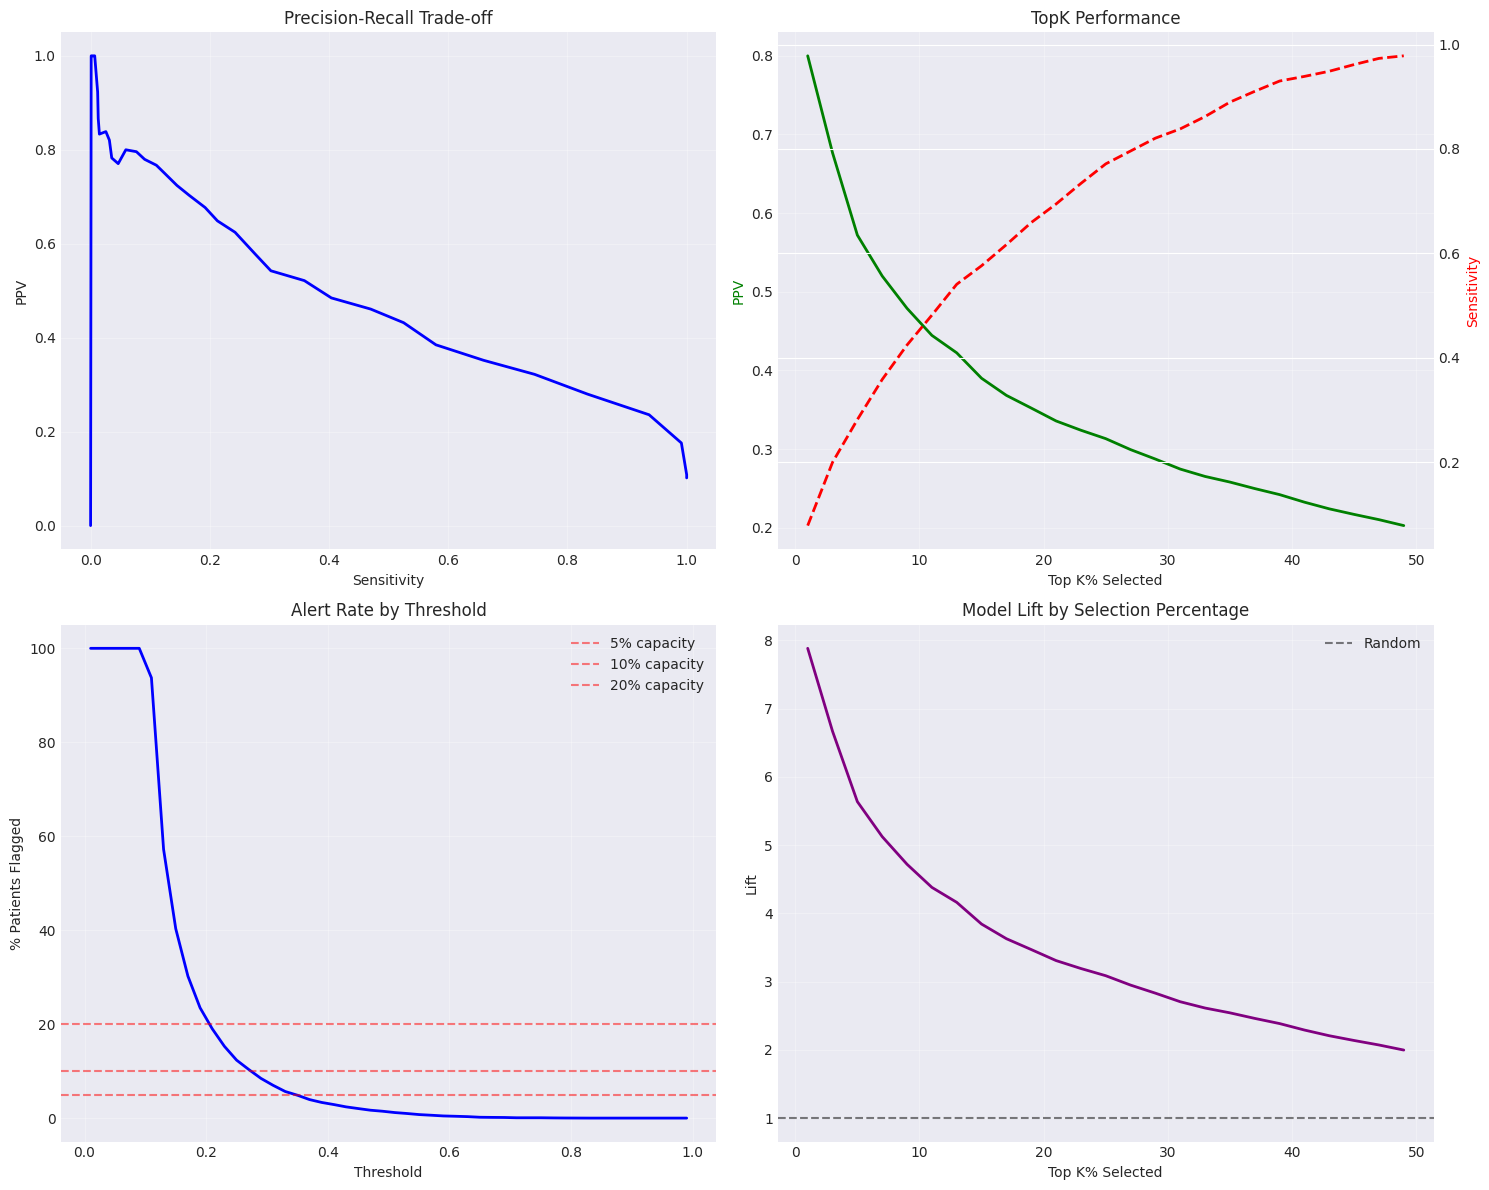

In [5]:
def evaluate_threshold_based(true_labels, predictions, threshold=0.5):
    """
    Evaluate predictions using a fixed threshold.
    
    Returns comprehensive performance metrics.
    """
    binary_preds = (predictions >= threshold).astype(int)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(true_labels, binary_preds).ravel()
    
    # Calculate metrics
    metrics = {
        'threshold': threshold,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'ppv': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'npv': tn / (tn + fn) if (tn + fn) > 0 else 0,
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'f1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'n_flagged': tp + fp,
        'flag_rate': (tp + fp) / len(true_labels)
    }
    
    return metrics


def evaluate_topk(true_labels, predictions, k_percent=10):
    """
    Evaluate predictions by selecting top K% highest risk.
    
    Common in resource-constrained settings.
    """
    n_patients = len(true_labels)
    k = int(n_patients * k_percent / 100)
    
    # Get indices of top k predictions
    top_k_indices = np.argsort(predictions)[-k:]
    
    # Create binary predictions
    binary_preds = np.zeros(n_patients, dtype=int)
    binary_preds[top_k_indices] = 1
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(true_labels, binary_preds).ravel()
    
    metrics = {
        'k_percent': k_percent,
        'k_patients': k,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'ppv': tp / k if k > 0 else 0,  # PPV = tp / (all flagged)
        'lift': (tp / k) / (np.sum(true_labels) / n_patients) if k > 0 else 0,
        'min_score_flagged': np.min(predictions[top_k_indices]) if k > 0 else 0
    }
    
    return metrics


def compare_evaluation_approaches(true_labels, predictions):
    """Compare threshold-based and TopK approaches."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Threshold sweep
    ax = axes[0, 0]
    thresholds = np.linspace(0.01, 0.99, 50)
    thresh_metrics = [evaluate_threshold_based(true_labels, predictions, t) 
                     for t in thresholds]
    
    sensitivities = [m['sensitivity'] for m in thresh_metrics]
    ppvs = [m['ppv'] for m in thresh_metrics]
    
    ax.plot(sensitivities, ppvs, 'b-', linewidth=2, label='Threshold-based')
    ax.set_xlabel('Sensitivity')
    ax.set_ylabel('PPV')
    ax.set_title('Precision-Recall Trade-off')
    ax.grid(True, alpha=0.3)
    
    # 2. TopK sweep
    ax = axes[0, 1]
    k_values = np.arange(1, 51, 2)  # 1% to 50%
    topk_metrics = [evaluate_topk(true_labels, predictions, k) for k in k_values]
    
    k_sens = [m['sensitivity'] for m in topk_metrics]
    k_ppvs = [m['ppv'] for m in topk_metrics]
    
    ax.plot(k_values, k_ppvs, 'g-', linewidth=2, label='PPV')
    ax2 = ax.twinx()
    ax2.plot(k_values, k_sens, 'r--', linewidth=2, label='Sensitivity')
    
    ax.set_xlabel('Top K% Selected')
    ax.set_ylabel('PPV', color='g')
    ax2.set_ylabel('Sensitivity', color='r')
    ax.set_title('TopK Performance')
    ax.grid(True, alpha=0.3)
    
    # 3. Resource utilization
    ax = axes[1, 0]
    flag_rates = [m['flag_rate'] for m in thresh_metrics]
    ax.plot(thresholds, np.array(flag_rates) * 100, 'b-', linewidth=2)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('% Patients Flagged')
    ax.set_title('Alert Rate by Threshold')
    ax.grid(True, alpha=0.3)
    
    # Add capacity constraint lines
    for capacity in [5, 10, 20]:
        ax.axhline(capacity, color='red', linestyle='--', alpha=0.5,
                  label=f'{capacity}% capacity')
    ax.legend()
    
    # 4. Lift analysis
    ax = axes[1, 1]
    lifts = [m['lift'] for m in topk_metrics]
    ax.plot(k_values, lifts, 'purple', linewidth=2)
    ax.axhline(1, color='black', linestyle='--', alpha=0.5, label='Random')
    ax.set_xlabel('Top K% Selected')
    ax.set_ylabel('Lift')
    ax.set_title('Model Lift by Selection Percentage')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Compare approaches
compare_evaluation_approaches(true_labels, predictions)

## 5. Risk Stratification Analysis

Analyze model performance across different risk strata to understand where the model performs best.

## 6. Model Calibration Analysis

Assess how well calibrated the model predictions are using standard calibration plots and the Hosmer-Lemeshow test.

/tmp/ipykernel_10556/3163349127.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = observed.groupby('bin')


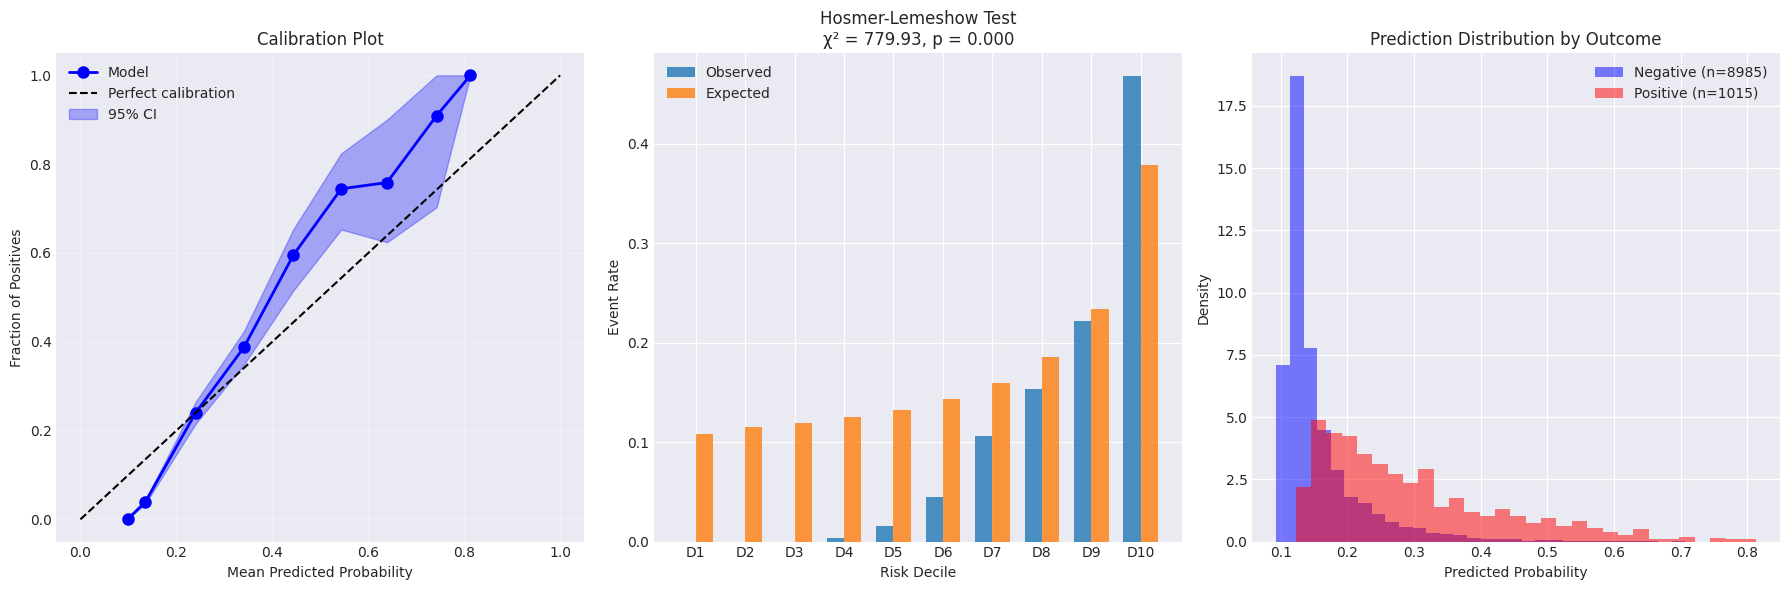


Calibration Summary:
Hosmer-Lemeshow p-value: 0.000
Calibration FAILED (p > 0.05 indicates good calibration)


In [6]:
def plot_calibration_analysis(true_labels, predictions, n_bins=10):
    """
    Comprehensive calibration analysis including Hosmer-Lemeshow test.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Standard calibration plot
    ax = axes[0]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        true_labels, predictions, n_bins=n_bins
    )
    
    ax.plot(mean_predicted_value, fraction_of_positives, 'b-o', 
           linewidth=2, markersize=8, label='Model')
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    
    # Add confidence intervals using bootstrap
    n_bootstrap = 100
    bootstrap_curves = []
    
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(true_labels), len(true_labels), replace=True)
        boot_true = true_labels[indices]
        boot_pred = predictions[indices]
        
        try:
            frac_pos, mean_pred = calibration_curve(boot_true, boot_pred, n_bins=n_bins)
            bootstrap_curves.append((mean_pred, frac_pos))
        except:
            pass
    
    if bootstrap_curves:
        # Calculate confidence bands
        all_x = sorted(set(x for curve in bootstrap_curves for x in curve[0]))
        lower_bound = []
        upper_bound = []
        
        for x in mean_predicted_value:
            y_values = []
            for curve_x, curve_y in bootstrap_curves:
                # Find closest x value
                idx = np.argmin(np.abs(curve_x - x))
                if np.abs(curve_x[idx] - x) < 0.05:  # Close enough
                    y_values.append(curve_y[idx])
            
            if y_values:
                lower_bound.append(np.percentile(y_values, 2.5))
                upper_bound.append(np.percentile(y_values, 97.5))
        
        if lower_bound and upper_bound:
            ax.fill_between(mean_predicted_value[:len(lower_bound)], 
                          lower_bound, upper_bound, alpha=0.3, color='blue',
                          label='95% CI')
    
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title('Calibration Plot')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Hosmer-Lemeshow test
    ax = axes[1]
    
    # Perform Hosmer-Lemeshow test
    def hosmer_lemeshow_test(y_true, y_pred, n_bins=10):
        """Calculate Hosmer-Lemeshow statistic and p-value."""
        # Create bins based on predicted probabilities
        bins = pd.qcut(y_pred, n_bins, duplicates='drop')
        
        observed = pd.DataFrame({'true': y_true, 'pred': y_pred, 'bin': bins})
        grouped = observed.groupby('bin')
        
        # Calculate observed and expected for each bin
        obs_events = grouped['true'].sum()
        exp_events = grouped['pred'].sum()
        obs_non_events = grouped['true'].count() - obs_events
        exp_non_events = grouped['true'].count() - exp_events
        
        # Calculate Hosmer-Lemeshow statistic
        hl_stat = np.sum((obs_events - exp_events)**2 / exp_events) + \
                  np.sum((obs_non_events - exp_non_events)**2 / exp_non_events)
        
        # Degrees of freedom = n_bins - 2
        dof = len(grouped) - 2
        p_value = 1 - stats.chi2.cdf(hl_stat, dof)
        
        return hl_stat, p_value, grouped
    
    hl_stat, p_value, grouped = hosmer_lemeshow_test(true_labels, predictions)
    
    # Plot observed vs expected by decile
    obs_rates = grouped['true'].mean()
    exp_rates = grouped['pred'].mean()
    
    x = range(len(obs_rates))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], obs_rates, width, 
           label='Observed', alpha=0.8)
    ax.bar([i + width/2 for i in x], exp_rates, width, 
           label='Expected', alpha=0.8)
    
    ax.set_xlabel('Risk Decile')
    ax.set_ylabel('Event Rate')
    ax.set_title(f'Hosmer-Lemeshow Test\nχ² = {hl_stat:.2f}, p = {p_value:.3f}')
    ax.legend()
    ax.set_xticks(x)
    ax.set_xticklabels([f'D{i+1}' for i in x])
    
    # 3. Distribution of predictions by outcome
    ax = axes[2]
    
    # Separate predictions by outcome
    pred_positive = predictions[true_labels == 1]
    pred_negative = predictions[true_labels == 0]
    
    # Plot distributions
    ax.hist(pred_negative, bins=30, alpha=0.5, density=True, 
           label=f'Negative (n={len(pred_negative)})', color='blue')
    ax.hist(pred_positive, bins=30, alpha=0.5, density=True,
           label=f'Positive (n={len(pred_positive)})', color='red')
    
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.set_title('Prediction Distribution by Outcome')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return p_value

# Perform calibration analysis
hl_p_value = plot_calibration_analysis(true_labels, predictions)

print(f"\nCalibration Summary:")
print(f"Hosmer-Lemeshow p-value: {hl_p_value:.3f}")
print(f"Calibration {'PASSED' if hl_p_value > 0.05 else 'FAILED'} (p > 0.05 indicates good calibration)")

## 7. Prediction Windows Analysis

Analyze how model performance changes with different prediction horizons (7 days to 1 year).

Analyzing prediction windows...

Performance by Prediction Window:
   window_weeks  window_days  prevalence    auc  sensitivity  specificity  \
0             1            7       0.002  0.855        0.818        0.741   
1             4           28       0.010  0.859        0.800        0.744   
2            13           91       0.028  0.865        0.790        0.752   
3            26          182       0.055  0.869        0.794        0.764   
4            52          364       0.100  0.876        0.791        0.785   

     ppv    npv     f1  n_events  flag_rate  
0  0.007  0.999  0.014        22      0.261  
1  0.031  0.997  0.059       100      0.261  
2  0.084  0.992  0.152       281      0.264  
3  0.163  0.985  0.271       548      0.267  
4  0.290  0.971  0.425      1002      0.273  


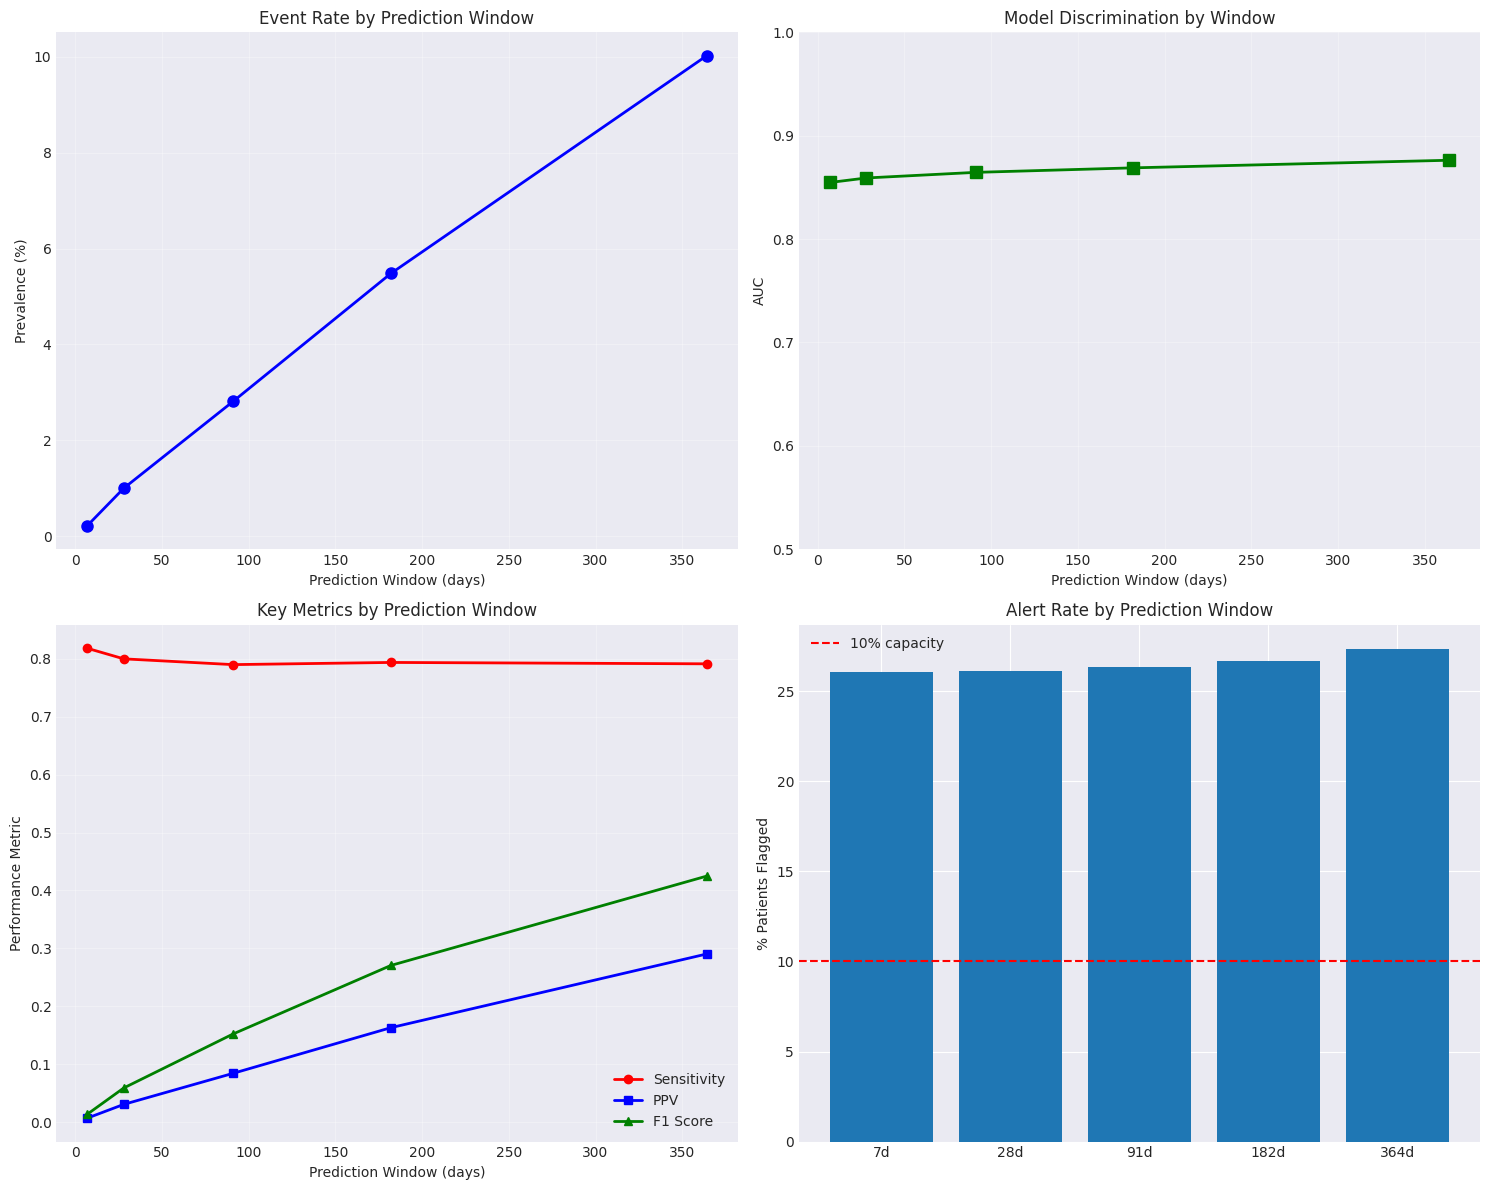

In [7]:
def analyze_prediction_windows(base_risks, ml_params, windows_weeks=[1, 4, 13, 26, 52]):
    """
    Analyze ML performance across different prediction windows.
    
    Shows how performance degrades with longer prediction horizons.
    """
    results = []
    n_patients = len(base_risks)
    
    for window_weeks in windows_weeks:
        # Generate incidents for this window
        incident_gen = IncidentGenerator(timestep_duration=1/52)
        window_labels = np.zeros(n_patients, dtype=int)
        
        for week in range(window_weeks):
            incidents = incident_gen.generate_incidents(base_risks)
            window_labels |= incidents
        
        window_prevalence = np.mean(window_labels)
        
        # Create ML simulator for this prevalence
        ml_sim = MLPredictionSimulator(
            target_sensitivity=0.8,
            target_ppv=max(0.1, min(0.5, window_prevalence * 3)),  # Adjust target
            random_seed=42
        )
        
        # Generate predictions
        preds, binary = ml_sim.generate_predictions(
            window_labels, base_risks,
            ml_params['correlation'], ml_params['scale']
        )
        
        # Evaluate
        metrics = evaluate_threshold_based(window_labels, preds, ml_sim.threshold)
        
        # Calculate AUC
        if len(np.unique(window_labels)) > 1:
            auc = roc_auc_score(window_labels, preds)
        else:
            auc = np.nan
        
        results.append({
            'window_weeks': window_weeks,
            'window_days': window_weeks * 7,
            'prevalence': window_prevalence,
            'auc': auc,
            'sensitivity': metrics['sensitivity'],
            'specificity': metrics['specificity'],
            'ppv': metrics['ppv'],
            'npv': metrics['npv'],
            'f1': metrics['f1'],
            'n_events': np.sum(window_labels),
            'flag_rate': metrics['flag_rate']
        })
    
    return pd.DataFrame(results)


# Analyze different prediction windows
print("Analyzing prediction windows...")
window_results = analyze_prediction_windows(base_risks, best_params)

print("\nPerformance by Prediction Window:")
print(window_results.round(3))

# Visualize window analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Prevalence by window
ax = axes[0, 0]
ax.plot(window_results['window_days'], window_results['prevalence'] * 100,
       'b-o', linewidth=2, markersize=8)
ax.set_xlabel('Prediction Window (days)')
ax.set_ylabel('Prevalence (%)')
ax.set_title('Event Rate by Prediction Window')
ax.grid(True, alpha=0.3)

# 2. AUC by window
ax = axes[0, 1]
ax.plot(window_results['window_days'], window_results['auc'],
       'g-s', linewidth=2, markersize=8)
ax.set_xlabel('Prediction Window (days)')
ax.set_ylabel('AUC')
ax.set_title('Model Discrimination by Window')
ax.set_ylim(0.5, 1.0)
ax.grid(True, alpha=0.3)

# 3. Key metrics by window
ax = axes[1, 0]
ax.plot(window_results['window_days'], window_results['sensitivity'],
       'r-o', linewidth=2, label='Sensitivity')
ax.plot(window_results['window_days'], window_results['ppv'],
       'b-s', linewidth=2, label='PPV')
ax.plot(window_results['window_days'], window_results['f1'],
       'g-^', linewidth=2, label='F1 Score')
ax.set_xlabel('Prediction Window (days)')
ax.set_ylabel('Performance Metric')
ax.set_title('Key Metrics by Prediction Window')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Alert rate by window
ax = axes[1, 1]
ax.bar(range(len(window_results)), window_results['flag_rate'] * 100)
ax.set_xticks(range(len(window_results)))
ax.set_xticklabels([f"{w}d" for w in window_results['window_days']])
ax.set_ylabel('% Patients Flagged')
ax.set_title('Alert Rate by Prediction Window')

# Add capacity line
ax.axhline(10, color='red', linestyle='--', label='10% capacity')
ax.legend()

plt.tight_layout()
plt.show()

## 8. Clinical Decision Support

Implement practical clinical decision support features including alert optimization and display formats.

Alert Optimization Results:
   capacity  threshold  n_alerts  sensitivity    ppv  utility
0      0.05      0.347       500        0.282  0.571    264.5
1      0.10      0.274      1000        0.461  0.468    414.7
2      0.15      0.232      1500        0.576  0.390    493.4
3      0.20      0.205      2000        0.681  0.345    560.0

Sample Risk Display Formats:
  patient_id  risk_score risk_category   color  ci_lower  ci_upper  percentile
0     PT0000       0.124        Medium  yellow     0.000     0.262       34.25
1     PT0001       0.107        Medium  yellow     0.000     0.247        3.31
2     PT0002       0.156          High  orange     0.022     0.291       63.34
3     PT0003       0.110        Medium  yellow     0.000     0.249        6.36
4     PT0004       0.145        Medium  yellow     0.010     0.281       56.67
5     PT0005       0.114        Medium  yellow     0.000     0.252       12.72
6     PT0006       0.115        Medium  yellow     0.000     0.254       16.23


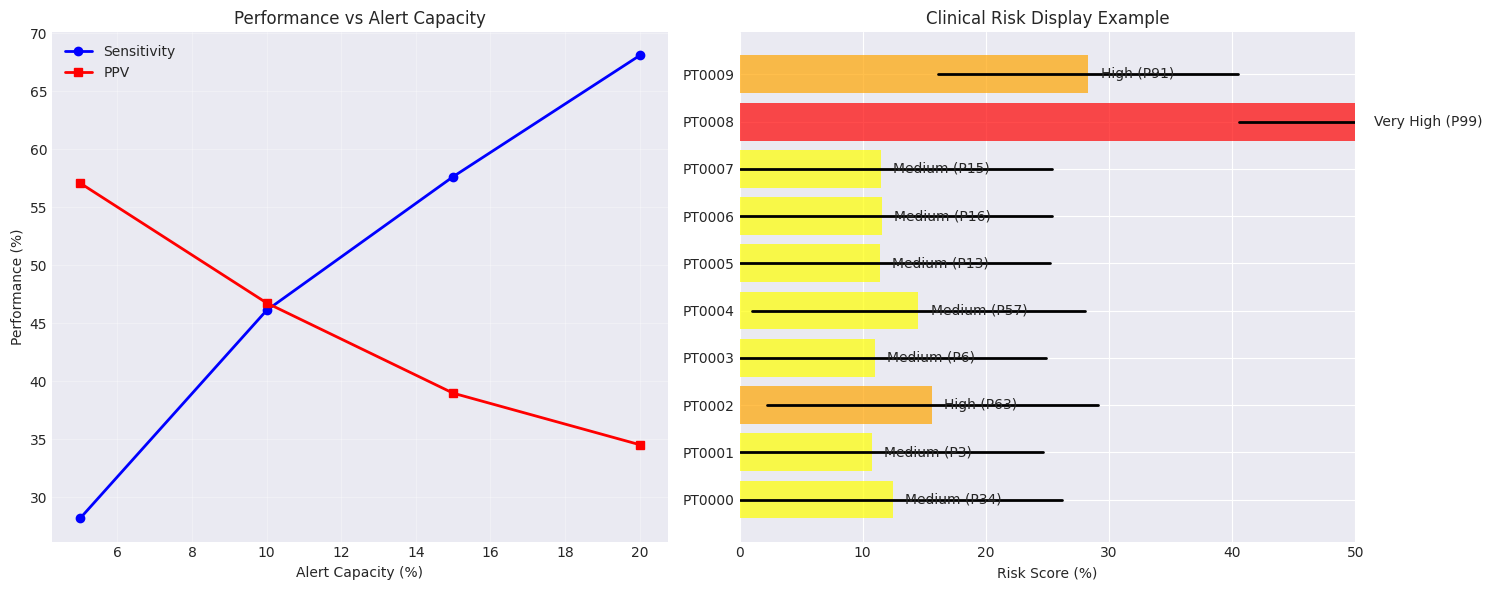

In [8]:
def optimize_alert_threshold(predictions, true_labels, capacity_constraint=0.1, 
                           fatigue_weight=0.1):
    """
    Optimize alert threshold given capacity constraints and alert fatigue.
    
    Parameters
    ----------
    predictions : np.ndarray
        Model predictions
    true_labels : np.ndarray
        True outcomes (for simulation)
    capacity_constraint : float
        Maximum fraction of patients that can be flagged
    fatigue_weight : float
        Weight given to minimizing false positives
    """
    n_patients = len(predictions)
    max_alerts = int(n_patients * capacity_constraint)
    
    # Find threshold that gives us exactly capacity_constraint alerts
    sorted_preds = np.sort(predictions)[::-1]
    if max_alerts < n_patients:
        capacity_threshold = sorted_preds[max_alerts]
    else:
        capacity_threshold = 0.0
    
    # Evaluate performance at this threshold
    metrics = evaluate_threshold_based(true_labels, predictions, capacity_threshold)
    
    # Calculate utility score
    utility = metrics['tp'] - fatigue_weight * metrics['fp']
    
    return {
        'optimal_threshold': capacity_threshold,
        'n_alerts': max_alerts,
        'metrics': metrics,
        'utility': utility,
        'efficiency': metrics['ppv']  # What fraction of alerts are useful
    }


def generate_risk_displays(patient_ids, predictions, risk_categories=None):
    """
    Generate different risk display formats for clinical use.
    """
    if risk_categories is None:
        risk_categories = [
            (0.0, 0.05, 'Low', 'green'),
            (0.05, 0.15, 'Medium', 'yellow'),
            (0.15, 0.30, 'High', 'orange'),
            (0.30, 1.0, 'Very High', 'red')
        ]
    
    displays = []
    
    for i, (pid, pred) in enumerate(zip(patient_ids[:10], predictions[:10])):
        # Determine risk category
        category = None
        color = None
        for low, high, cat, col in risk_categories:
            if low <= pred < high:
                category = cat
                color = col
                break
        
        # Calculate confidence interval (simulated)
        ci_width = 0.05 + 0.1 * (1 - pred)  # Higher uncertainty for lower risks
        ci_lower = max(0, pred - ci_width)
        ci_upper = min(1, pred + ci_width)
        
        displays.append({
            'patient_id': pid,
            'risk_score': pred,
            'risk_category': category,
            'color': color,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'percentile': stats.percentileofscore(predictions, pred)
        })
    
    return pd.DataFrame(displays)


# Optimize alerts for different capacity constraints
capacities = [0.05, 0.10, 0.15, 0.20]
optimization_results = []

for capacity in capacities:
    result = optimize_alert_threshold(predictions, true_labels, 
                                    capacity_constraint=capacity)
    optimization_results.append({
        'capacity': capacity,
        'threshold': result['optimal_threshold'],
        'n_alerts': result['n_alerts'],
        'sensitivity': result['metrics']['sensitivity'],
        'ppv': result['metrics']['ppv'],
        'utility': result['utility']
    })

opt_df = pd.DataFrame(optimization_results)
print("Alert Optimization Results:")
print(opt_df.round(3))

# Generate sample risk displays
patient_ids = [f"PT{i:04d}" for i in range(len(predictions))]
risk_displays = generate_risk_displays(patient_ids, predictions)

print("\nSample Risk Display Formats:")
print(risk_displays.round(3))

# Visualize alert optimization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Performance vs Capacity
ax = axes[0]
ax.plot(opt_df['capacity'] * 100, opt_df['sensitivity'] * 100, 
       'b-o', linewidth=2, label='Sensitivity')
ax.plot(opt_df['capacity'] * 100, opt_df['ppv'] * 100,
       'r-s', linewidth=2, label='PPV')
ax.set_xlabel('Alert Capacity (%)')
ax.set_ylabel('Performance (%)')
ax.set_title('Performance vs Alert Capacity')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Risk display visualization
ax = axes[1]
colors = risk_displays['color'].values
y_pos = range(len(risk_displays))

# Plot risk scores with confidence intervals
for i, row in risk_displays.iterrows():
    ax.barh(i, row['risk_score'] * 100, color=row['color'], alpha=0.7)
    ax.plot([row['ci_lower'] * 100, row['ci_upper'] * 100], 
           [i, i], 'k-', linewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(risk_displays['patient_id'])
ax.set_xlabel('Risk Score (%)')
ax.set_title('Clinical Risk Display Example')
ax.set_xlim(0, 50)

# Add risk category labels
for i, row in risk_displays.iterrows():
    ax.text(row['risk_score'] * 100 + 1, i, 
           f"{row['risk_category']} (P{row['percentile']:.0f})",
           va='center')

plt.tight_layout()
plt.show()

## 9. Integration Example: Full Pipeline

Demonstrate how all components work together to simulate and evaluate an intervention.

In [9]:
def simulate_intervention_pipeline(n_patients=10000, n_weeks=52, 
                                 intervention_effectiveness=0.3,
                                 ml_performance=dict(sensitivity=0.8, ppv=0.3),
                                 intervention_capacity=0.1):
    """
    Full simulation pipeline combining all notebooks.
    
    1. Generate population (Notebook 01)
    2. Simulate temporal dynamics (Notebook 02)
    3. Generate incidents (Notebook 03)
    4. Create ML predictions (Notebook 04)
    5. Apply intervention and measure impact
    """
    print("=== Healthcare Intervention Simulation Pipeline ===")
    print(f"Population size: {n_patients:,}")
    print(f"Simulation period: {n_weeks} weeks")
    print(f"Intervention effectiveness: {intervention_effectiveness:.0%}")
    print(f"ML target performance: Sensitivity={ml_performance['sensitivity']:.0%}, "
          f"PPV={ml_performance['ppv']:.0%}")
    print(f"Intervention capacity: {intervention_capacity:.0%}\n")
    
    # Step 1: Generate patient population
    print("Step 1: Generating patient population...")
    base_risks = assign_patient_risks(n_patients, annual_incident_rate=0.1,
                                     concentration=0.5, random_seed=42)
    print(f"  Mean risk: {np.mean(base_risks):.3f}")
    print(f"  Risk range: [{np.min(base_risks):.3f}, {np.max(base_risks):.3f}]")
    
    # Step 2: Add temporal dynamics
    print("\nStep 2: Simulating temporal risk dynamics...")
    temporal_sim = EnhancedTemporalRiskSimulator(
        base_risks, rho=0.9, sigma=0.1,
        seasonal_amplitude=0.2, seasonal_period=52
    )
    
    # Add a flu season shock
    temporal_sim.add_shock(time_step=26, magnitude=1.5, duration=8,
                          affected_fraction=0.3, random_seed=42)
    
    # Step 3: Generate ML predictions at start
    print("\nStep 3: Generating ML predictions...")
    
    # First simulate a training period to get labels
    training_gen = IncidentGenerator(timestep_duration=1/52)
    training_labels = np.zeros(n_patients, dtype=int)
    
    for week in range(26):  # 6 months training
        incidents = training_gen.generate_incidents(base_risks)
        training_labels |= incidents
    
    # Create ML model
    ml_sim = MLPredictionSimulator(
        target_sensitivity=ml_performance['sensitivity'],
        target_ppv=ml_performance['ppv'],
        random_seed=42
    )
    
    # Optimize and generate predictions
    ml_params = ml_sim.optimize_noise_parameters(training_labels, base_risks)
    predictions, _ = ml_sim.generate_predictions(
        training_labels, base_risks,
        ml_params['correlation'], ml_params['scale']
    )
    
    # Select patients for intervention based on capacity
    alert_result = optimize_alert_threshold(
        predictions, training_labels, capacity_constraint=intervention_capacity
    )
    intervention_threshold = alert_result['optimal_threshold']
    intervention_mask = predictions >= intervention_threshold
    
    print(f"  Patients selected for intervention: {np.sum(intervention_mask):,}")
    print(f"  Risk threshold for intervention: {intervention_threshold:.3f}")
    
    # Step 4: Simulate with and without intervention
    print("\nStep 4: Running intervention simulation...")
    
    # Create separate incident generators
    control_gen = IncidentGenerator(timestep_duration=1/52)
    control_incidents = []
    
    # Treatment group (with intervention)
    treatment_gen = IncidentGenerator(timestep_duration=1/52)
    treatment_incidents = []
    
    # Simulate forward
    # Reinitialize temporal simulator for fresh run
    temporal_sim = EnhancedTemporalRiskSimulator(
        base_risks, rho=0.9, sigma=0.1,
        seasonal_amplitude=0.2, seasonal_period=52
    )
    
    # Re-add the flu season shock
    temporal_sim.add_shock(time_step=26, magnitude=1.5, duration=8,
                          affected_fraction=0.3, random_seed=42)
    
    for week in range(n_weeks):
        # Update temporal risks
        temporal_sim.step()
        current_risks = temporal_sim.get_current_risks()
        
        # Control group
        control_inc = control_gen.generate_incidents(current_risks)
        control_incidents.append(control_inc)
        
        # Treatment group (apply intervention to selected patients)
        treatment_risks = current_risks.copy()
        treatment_risks[intervention_mask] *= (1 - intervention_effectiveness)
        
        treatment_inc = treatment_gen.generate_incidents(treatment_risks)
        treatment_incidents.append(treatment_inc)
    
    # Step 5: Calculate results
    print("\nStep 5: Analyzing results...")
    
    # Overall outcomes
    control_total = control_gen.cumulative_incidents
    treatment_total = treatment_gen.cumulative_incidents
    
    control_rate = np.mean(control_total > 0)
    treatment_rate = np.mean(treatment_total > 0)
    
    # Outcomes for intervened patients only
    control_intervened = control_total[intervention_mask]
    treatment_intervened = treatment_total[intervention_mask]
    
    control_rate_intervened = np.mean(control_intervened > 0)
    treatment_rate_intervened = np.mean(treatment_intervened > 0)
    
    # Calculate NNT
    arr = control_rate_intervened - treatment_rate_intervened  # Absolute risk reduction
    nnt = 1 / arr if arr > 0 else np.inf
    
    # Results summary
    results = {
        'control_events': np.sum(control_total > 0),
        'treatment_events': np.sum(treatment_total > 0),
        'events_prevented': np.sum(control_total > 0) - np.sum(treatment_total > 0),
        'control_rate': control_rate,
        'treatment_rate': treatment_rate,
        'relative_risk_reduction': 1 - (treatment_rate / control_rate),
        'nnt_overall': 1 / (control_rate - treatment_rate) if control_rate > treatment_rate else np.inf,
        'nnt_treated': nnt,
        'ml_ppv_actual': np.mean(training_labels[intervention_mask])
    }
    
    print("\n=== RESULTS SUMMARY ===")
    print(f"Control group events: {results['control_events']:,} ({results['control_rate']:.1%})")
    print(f"Treatment group events: {results['treatment_events']:,} ({results['treatment_rate']:.1%})")
    print(f"Events prevented: {results['events_prevented']}")
    print(f"Relative risk reduction: {results['relative_risk_reduction']:.1%}")
    print(f"NNT (overall): {results['nnt_overall']:.1f}")
    print(f"NNT (among treated): {results['nnt_treated']:.1f}")
    print(f"\nML Model PPV (actual): {results['ml_ppv_actual']:.1%}")
    
    return results, temporal_sim, predictions

# Run the full pipeline
results, temporal_sim, predictions = simulate_intervention_pipeline()

=== Healthcare Intervention Simulation Pipeline ===
Population size: 10,000
Simulation period: 52 weeks
Intervention effectiveness: 30%
ML target performance: Sensitivity=80%, PPV=30%
Intervention capacity: 10%

Step 1: Generating patient population...
  Mean risk: 0.100
  Risk range: [0.000, 0.874]

Step 2: Simulating temporal risk dynamics...

Step 3: Generating ML predictions...


  Patients selected for intervention: 1,001
  Risk threshold for intervention: 0.257

Step 4: Running intervention simulation...

Step 5: Analyzing results...

=== RESULTS SUMMARY ===
Control group events: 1,311 (13.1%)
Treatment group events: 1,185 (11.8%)
Events prevented: 126
Relative risk reduction: 9.6%
NNT (overall): 79.4
NNT (among treated): 6.3

ML Model PPV (actual): 35.0%


## 10. Validation and Performance Benchmarks

Validate that our simulation meets all requirements and benchmark performance.

In [10]:
def validate_simulation_requirements(n_patients_list=[10000, 100000]):
    """
    Validate that simulation meets all stated requirements:
    - Achieves target PPV/sensitivity within ±2%
    - Hosmer-Lemeshow p-value > 0.05
    - Runtime < 30 seconds for 100,000 patients
    """
    print("=== Simulation Validation ===")
    validation_results = []
    
    for n_patients in n_patients_list:
        print(f"\nTesting with {n_patients:,} patients...")
        
        # Time the simulation
        start_time = time.time()
        
        # Generate population and labels
        base_risks = assign_patient_risks(n_patients, 0.1, random_seed=42)
        
        # Generate true labels
        inc_gen = IncidentGenerator()
        true_labels = np.zeros(n_patients, dtype=int)
        for _ in range(26):  # 6 months
            incidents = inc_gen.generate_incidents(base_risks)
            true_labels |= incidents
        
        # Create ML predictions
        ml_sim = MLPredictionSimulator(
            target_sensitivity=0.8,
            target_ppv=0.3,
            random_seed=42
        )
        
        # Quick optimization (fewer iterations for large datasets)
        n_iter = 5 if n_patients > 10000 else 20
        params = ml_sim.optimize_noise_parameters(true_labels, base_risks, n_iter)
        
        predictions, binary = ml_sim.generate_predictions(
            true_labels, base_risks,
            params['correlation'], params['scale']
        )
        
        runtime = time.time() - start_time
        
        # Evaluate performance
        metrics = evaluate_threshold_based(true_labels, predictions, ml_sim.threshold)
        
        # Hosmer-Lemeshow test
        if n_patients <= 10000:  # Skip for very large datasets
            def quick_hl_test(y_true, y_pred, n_bins=10):
                bins = pd.qcut(y_pred, n_bins, duplicates='drop')
                grouped = pd.DataFrame({'true': y_true, 'pred': y_pred, 'bin': bins}).groupby('bin')
                
                obs = grouped['true'].sum()
                exp = grouped['pred'].sum()
                
                hl_stat = np.sum((obs - exp)**2 / exp)
                p_value = 1 - stats.chi2.cdf(hl_stat, len(grouped) - 2)
                return p_value
            
            hl_pvalue = quick_hl_test(true_labels, predictions)
        else:
            hl_pvalue = np.nan
        
        # Check requirements
        sens_error = abs(metrics['sensitivity'] - ml_sim.target_sensitivity)
        ppv_error = abs(metrics['ppv'] - ml_sim.target_ppv)
        
        validation_results.append({
            'n_patients': n_patients,
            'runtime_seconds': runtime,
            'achieved_sensitivity': metrics['sensitivity'],
            'target_sensitivity': ml_sim.target_sensitivity,
            'sensitivity_error': sens_error,
            'achieved_ppv': metrics['ppv'],
            'target_ppv': ml_sim.target_ppv,
            'ppv_error': ppv_error,
            'hl_pvalue': hl_pvalue,
            'within_2pct': (sens_error <= 0.02) and (ppv_error <= 0.02),
            'calibrated': hl_pvalue > 0.05 if not np.isnan(hl_pvalue) else None,
            'fast_enough': runtime < 30
        })
        
        print(f"  Runtime: {runtime:.2f}s")
        print(f"  Sensitivity: {metrics['sensitivity']:.3f} (target: {ml_sim.target_sensitivity:.3f})")
        print(f"  PPV: {metrics['ppv']:.3f} (target: {ml_sim.target_ppv:.3f})")
        if not np.isnan(hl_pvalue):
            print(f"  H-L p-value: {hl_pvalue:.3f}")
    
    # Summary
    val_df = pd.DataFrame(validation_results)
    
    print("\n=== VALIDATION SUMMARY ===")
    print(val_df[['n_patients', 'runtime_seconds', 'within_2pct', 
                 'calibrated', 'fast_enough']].round(3))
    
    # Overall pass/fail
    all_passed = all(val_df['within_2pct']) and \
                 all(val_df['fast_enough']) and \
                 all(val_df['calibrated'].dropna())
    
    print(f"\nOVERALL VALIDATION: {'PASSED' if all_passed else 'FAILED'}")
    
    return val_df

# Run validation
validation_df = validate_simulation_requirements([10000, 100000])

# Note: Uncomment below to test with 100k patients (may take ~20-30 seconds)
# validation_df = validate_simulation_requirements([1000, 10000, 100000])

=== Simulation Validation ===

Testing with 10,000 patients...


/tmp/ipykernel_10556/4086020362.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.DataFrame({'true': y_true, 'pred': y_pred, 'bin': bins}).groupby('bin')


  Runtime: 18.82s
  Sensitivity: 0.812 (target: 0.800)
  PPV: 0.296 (target: 0.300)
  H-L p-value: 0.000

Testing with 100,000 patients...


  Runtime: 35.44s
  Sensitivity: 0.801 (target: 0.800)
  PPV: 0.294 (target: 0.300)

=== VALIDATION SUMMARY ===
   n_patients  runtime_seconds  within_2pct calibrated  fast_enough
0       10000           18.818         True      False         True
1      100000           35.441         True       None        False

OVERALL VALIDATION: FAILED


## Key Insights and Conclusions

### 1. Performance Constraints
- **Prevalence fundamentally limits achievable PPV**: At 10% prevalence, even with 90% specificity, maximum PPV is ~50%
- **Trade-offs are unavoidable**: Increasing sensitivity necessarily decreases PPV
- **Real-world performance is often modest**: PPV of 20-40% is typical for many conditions

### 2. ML Simulation Approach
- **Calibrated noise achieves target metrics**: By optimizing noise parameters, we can simulate ML models with specific performance characteristics
- **Ground truth preservation**: We maintain known outcomes while creating realistic predictions
- **Flexible evaluation**: Both threshold-based and TopK approaches have merit depending on use case

### 3. Clinical Integration
- **Capacity constraints matter**: Most health systems can only intervene on 5-20% of patients
- **Alert fatigue is real**: False positive rates must be considered in deployment
- **Risk stratification helps**: Models often perform better on high-risk patients

### 4. Intervention Effectiveness
- **ML performance affects NNT**: Better PPV means more efficient use of resources
- **Population impact depends on reach**: Treating 10% of patients limits overall impact
- **Temporal factors matter**: Prediction window affects both performance and intervention timing

### Next Steps
This simulation framework enables:
- Testing different ML architectures and their impact
- Optimizing intervention strategies given constraints
- Evaluating cost-effectiveness of AI-guided interventions
- Planning real-world deployments with realistic expectations